<h1 align="center">MDSC-304(P) Miniproject</h1>
<h3 align="right">Registration number: 20233</h3>

**Project Statement**: Assisting Sparkify music service for churn prediction

This project uses users event data from Sparkify, which is an imaginary digital music service similar to Spotify or Pandora, to build a model to predict users’ churn. In this project, I am going to analyze Sparkify data and create a machine learning model to predict churn.

**Dataset Link**: https://media.githubusercontent.com/media/angang-li/sparkify/master/mini_sparkify_event_data.json

# Import required libraries

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from time import time
from functools import reduce

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import MinMaxScaler
from pyspark.mllib.evaluation import MulticlassMetrics

%matplotlib inline
sns.set_theme()

# Create a spark session

In [2]:
spark = spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Explore the Dataset

In [3]:
path = "data/mini_sparkify_event_data.json"
df = spark.read.json(path)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



|#| Column | Type | Description |
| --- | --- | --- | --- |
| 1 | userId | string | Unique identifier of the user, the event is related to |
| 2 | artist | string | Name of the artist related to the song related to the event |
| 3 | auth | string | “Logged in” or “Cancelled” |
| 4 | firstName | string | First name of the user |
| 5 | gender | string | Gender of the user, “F” or “M” |
| 6 | itemInSession | bigint | Item in session |
| 7 | lastName | string | Last name of the user |
| 8 | length | double | Length of the song related to the event |
| 9 | level | string | Level of the user’s subscription, “free” or “paid”. User can change the level, so events for the same user can have different levels |
| 10 | location | string | Location of the user at the time of the event |
| 11 | method | string | “GET” or “PUT” |
| 12 | page | string | Type of action: “NextSong”, “Login”, “Thumbs Up” etc. |
| 13 | registration | bigint | Registration number|
| 14 | sessionId | bigint | Session id|
| 15 | song | string | Name of the song related to the event |
| 16 | status | bigint | Response status: 200, 404, 307 |
| 17 | ts | bigint | Timestamp of the event |
| 18 | userAgent | string | Agent, which user used for the event, for example, “Mozilla/5.0” |

In [5]:
print((df.count(), len(df.columns)))

(286500, 18)


In [6]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [7]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

# Exploratory Data Analysis 

In [8]:
for col in df.columns:
    print(col,  df.filter((df[col].isNull()) | (df[col] == "")).count())

artist 58392
auth 0
firstName 8346
gender 8346
itemInSession 0
lastName 8346
length 58392
level 0
location 8346
method 0
page 0
registration 8346
sessionId 0
song 58392
status 0
ts 0
userAgent 8346
userId 8346


In [9]:
df_clean = df.dropna(how="any",subset="userId")
df_clean = df_clean.filter(df_clean['userId'] != '')
df_clean.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [10]:
print((df_clean.count(), len(df_clean.columns)))

(278154, 18)


In [11]:
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_clean = df_clean.withColumn('event_time', get_date('ts'))
df_clean = df_clean.withColumn('registration_time', get_date('registration'))
df_clean.select('event_time').show(5)

+-------------------+
|         event_time|
+-------------------+
|2018-10-01 05:31:57|
|2018-10-01 05:33:00|
|2018-10-01 05:36:34|
|2018-10-01 05:36:56|
|2018-10-01 05:41:16|
+-------------------+
only showing top 5 rows



In [12]:
print(df_clean.agg({'event_time': 'min'}).collect()[0][0])
print(df_clean.agg({'event_time': 'max'}).collect()[0][0])

2018-10-01 05:31:57


2018-12-03 06:41:16


In [13]:
get_location = udf(lambda x:x[-2:])
df_clean = df_clean.withColumn('location_state', get_location(df_clean.location))
df_clean.select('location_state').distinct().show(5)

+--------------+
|location_state|
+--------------+
|            AZ|
|            SC|
|            LA|
|            NJ|
|            OR|
+--------------+
only showing top 5 rows



In [14]:
df_clean.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [15]:
downgrade_event = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())
df_clean = df_clean.withColumn('downgrade_event', downgrade_event('page'))
df_clean = df_clean.withColumn('downgrade', max('downgrade_event').over(Window.partitionBy('userId')))

In [16]:
churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df_clean = df_clean.withColumn('churn_event', churn_event('page'))
df_clean = df_clean.withColumn('churn', max('churn_event').over(Window.partitionBy('userId')))

In [17]:
df_clean.show(5)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-------------------+--------------+---------------+---------+-----------+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|         event_time|  registration_time|location_state|downgrade_event|downgrade|churn_event|churn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-------------------+--------------+---------------+---------+-----------+-----+
|Sleeping With Sirens|Logged In| Dari

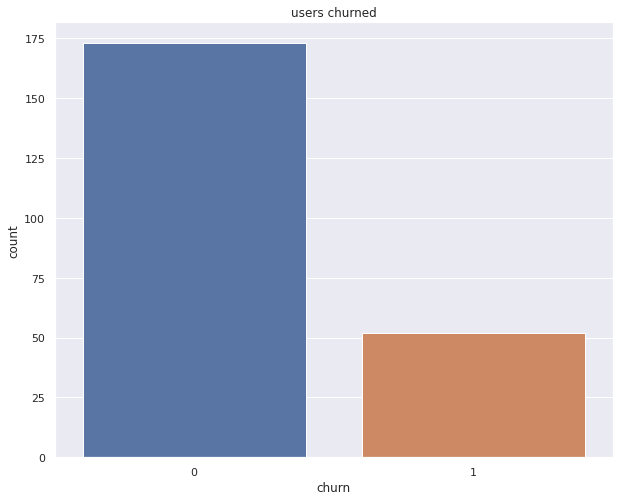

In [18]:
num_churn = df_clean.dropDuplicates(['userId', 'churn']).groupby(['churn']).count().toPandas()

plt.figure(figsize=(10, 8))
ax = sns.barplot(x='churn', y='count', data=num_churn)
plt.xlabel('churn')
plt.ylabel('count')
plt.title('users churned');

Text(0.5, 1.0, 'Users downgraded')

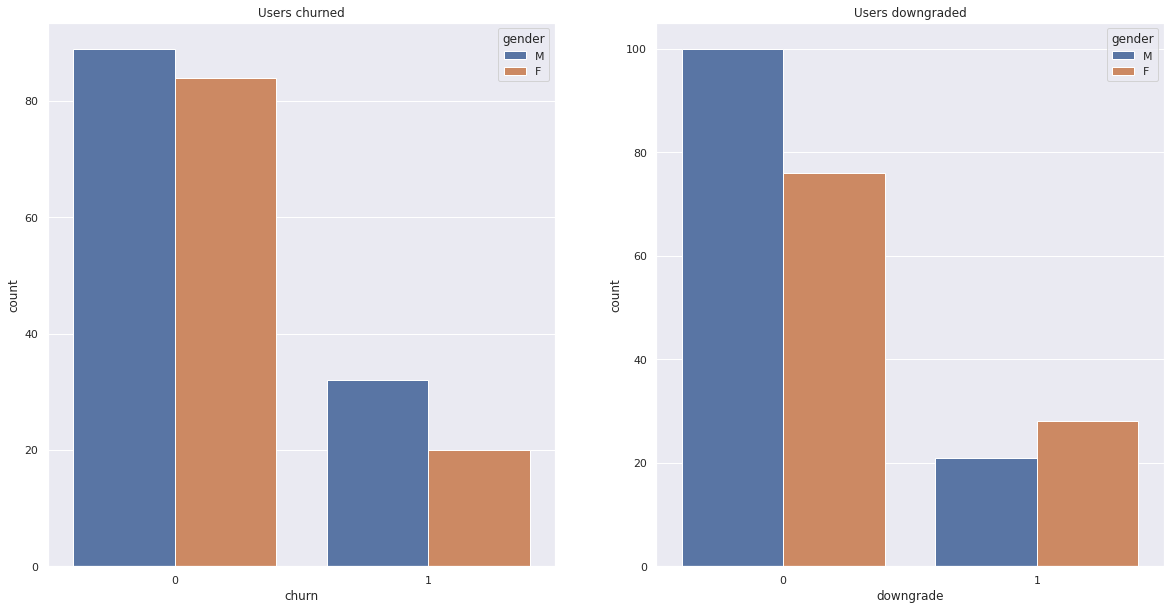

In [19]:
churn_gender = df_clean.dropDuplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().sort('churn').toPandas()
downgrade_gender = df_clean.dropDuplicates(['userId', 'gender']).groupby(['downgrade', 'gender']).count().sort('downgrade').toPandas()

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.barplot(x='churn', y='count', hue='gender', data=churn_gender, ax=ax1) 
ax1.set_xlabel('churn')
ax1.set_ylabel('count')
ax1.legend(title='gender', loc='best')
ax1.set_title('Users churned')

sns.barplot(x='downgrade', y='count', hue='gender', data=downgrade_gender, ax=ax2)
ax2.set_xlabel('downgrade')
ax2.set_ylabel('count')
ax2.legend(title='gender', loc='best')
ax2.set_title('Users downgraded')

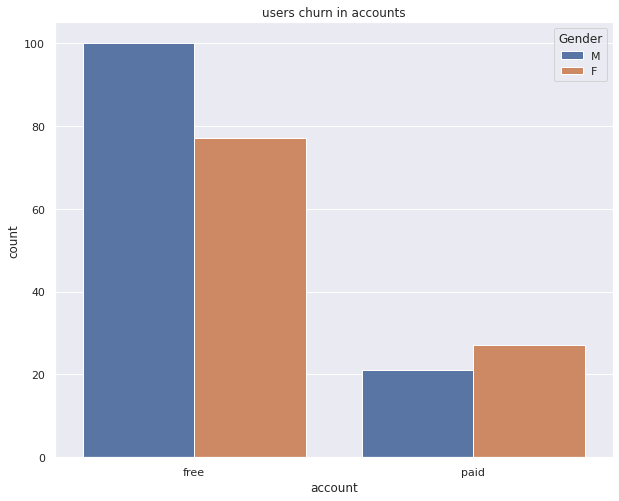

In [20]:
account_churn = df_clean.dropDuplicates(['userId', 'gender']).groupby(['gender', 'level']).count().toPandas()

plt.figure(figsize=(10, 8))
ax = sns.barplot(x='level', y='count',hue='gender', data=account_churn);
plt.xlabel('account')
plt.ylabel('count')
plt.title('users churn in accounts')
plt.legend(title='Gender', loc='best')

Text(0.5, 1.0, 'Using Sparkify before churn')

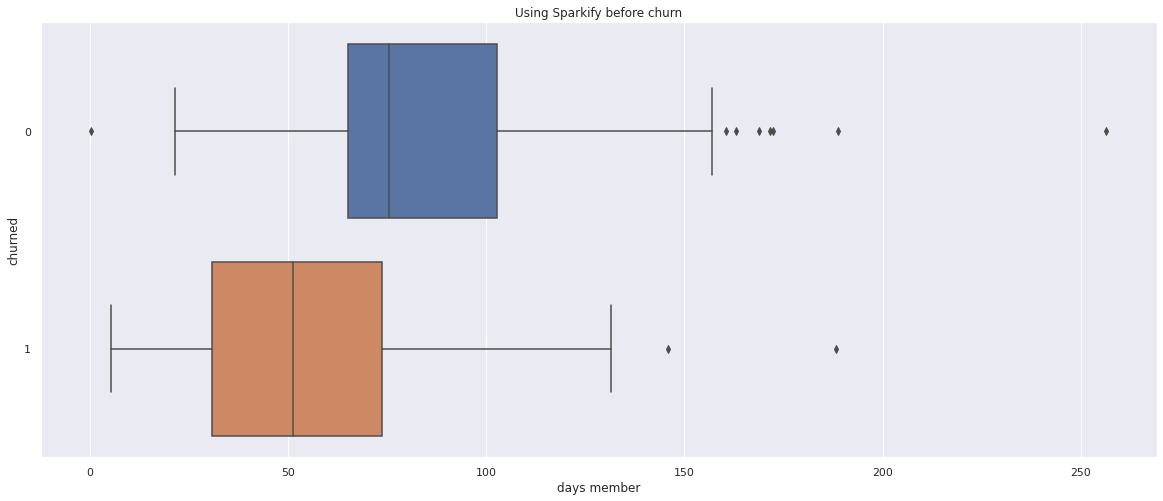

In [21]:
lifetime = df_clean.select('userId','registration','ts','churn')
lifetime = lifetime.withColumn('lifetime',(df_clean.ts - df_clean.registration)/(1000*3600*24)).groupBy('userId','churn').agg({'lifetime':'max'})
lifetime = lifetime.withColumnRenamed('max(lifetime)','lifetime').select('userId', 'churn', 'lifetime').toPandas()

plt.figure(figsize=(20, 8))
ax = sns.boxplot(x='lifetime', y='churn', data=lifetime, orient='h')
plt.xlabel('days member');
plt.ylabel('churned');
plt.title('Using Sparkify before churn')

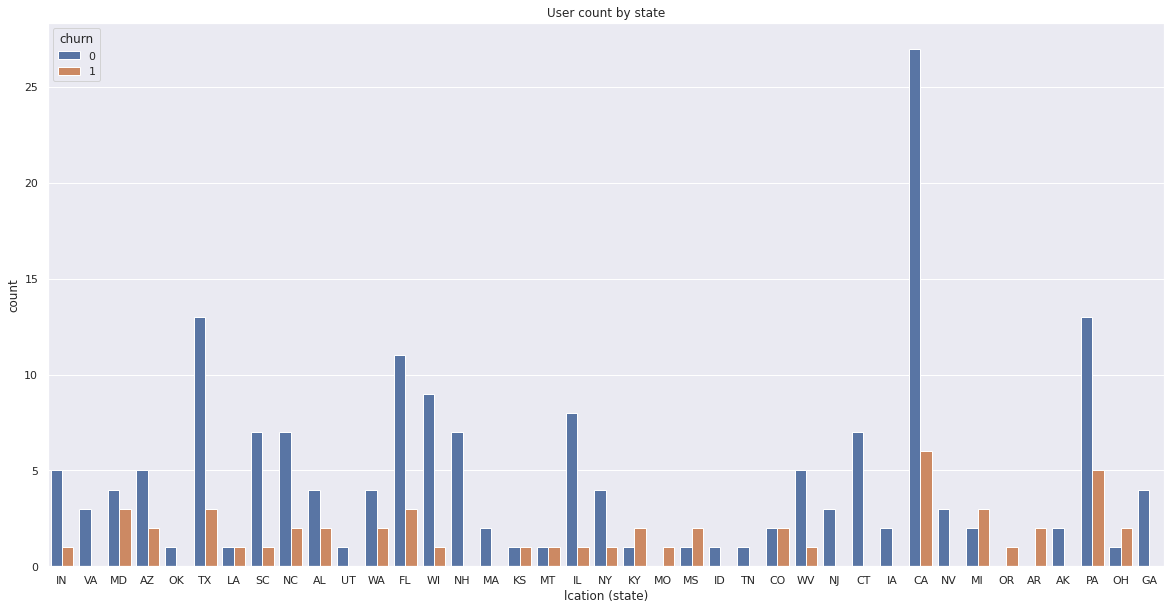

In [22]:
location_state = df_clean.dropDuplicates(['userId', 'location_state']).groupby(['location_state', 'churn']).count().toPandas()

plt.figure(figsize=(20, 10))
ax = sns.barplot(x='location_state', y='count', hue='churn', data=location_state)
plt.xlabel('lcation (state)')
plt.ylabel('count')
plt.title('User count by state')
plt.legend(title='churn', loc='upper left')

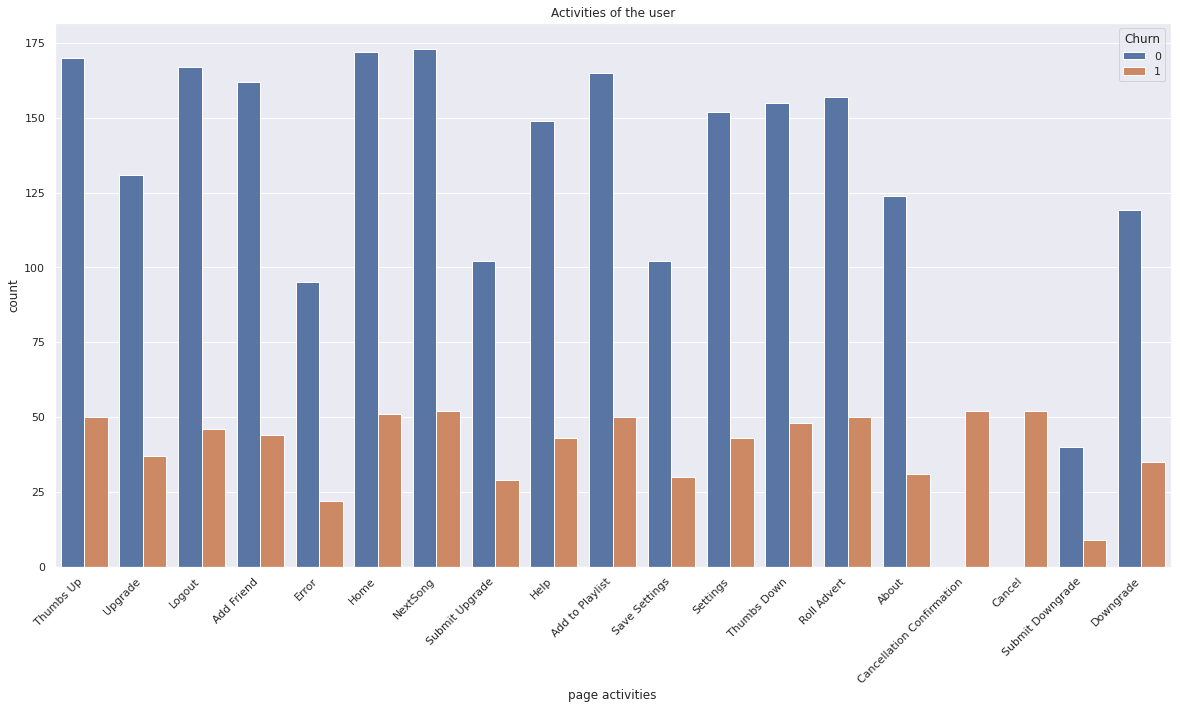

In [23]:
page_churn = df_clean.dropDuplicates(['userId', 'page']).groupby(['page', 'churn']).count().toPandas()

plt.figure(figsize=(20, 10))
ax = sns.barplot(x='page', y='count',hue='churn', data=page_churn)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('page activities')
plt.ylabel('count')
plt.title('Activities of the user')
plt.legend(title='Churn', loc='best');

Text(0.5, 1.0, 'How long does the users listen to music')

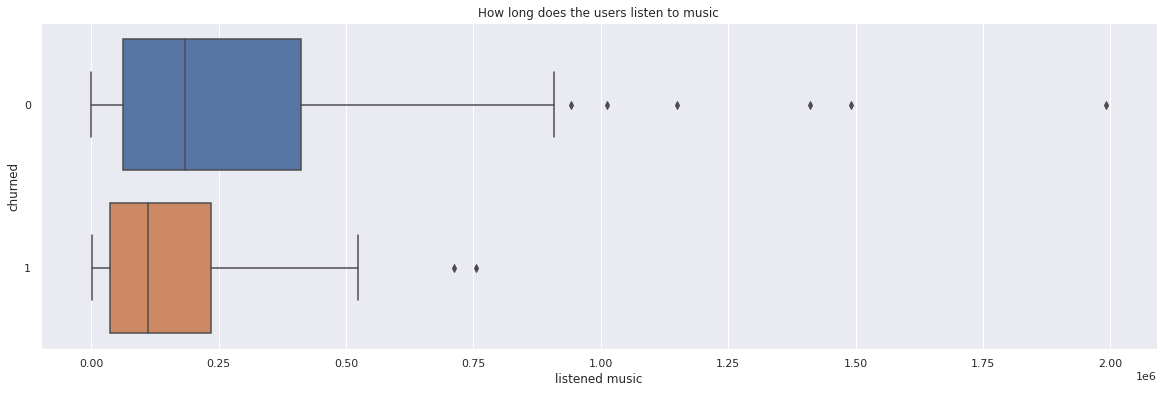

In [24]:
sum_listened = df_clean.select('userID','length','churn').groupby(['userID','churn']).sum().withColumnRenamed('sum(length)', 'listen_time').toPandas()

fig = plt.figure(figsize=(20, 6))

ax = sns.boxplot(x='listen_time', y='churn', data=sum_listened, orient='h')
plt.xlabel('listened music')
plt.ylabel('churned')
plt.title('How long does the users listen to music')

# Feature Engineering

In [25]:
gender = df_clean.select(['userId', 'gender']).dropDuplicates(['userId']).replace(['F', 'M'], ['0', '1'], 'gender')
df_gender = gender.withColumn('gender', gender.gender.cast('int'))
df_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|100010|     0|
|200002|     1|
|   125|     1|
|   124|     0|
|    51|     1|
+------+------+
only showing top 5 rows



In [26]:
payment = df_clean.select(['userId', 'level']).dropDuplicates(['userId']).replace(['paid', 'free'], ['0', '1'], 'level')
df_payment = payment.withColumn('level', payment.level.cast('int'))
df_payment.show(5)

+------+-----+
|userId|level|
+------+-----+
|100010|    1|
|200002|    1|
|   125|    1|
|   124|    0|
|    51|    0|
+------+-----+
only showing top 5 rows



In [27]:
downgrade = df_clean.select(['userId','downgrade']).dropDuplicates(['userId']) 
df_downgrade = downgrade.withColumn('downgrade', downgrade.downgrade.cast('int'))
df_downgrade.show(5)

+------+---------+
|userId|downgrade|
+------+---------+
|100010|        0|
|200002|        0|
|   125|        0|
|   124|        0|
|    51|        0|
+------+---------+
only showing top 5 rows



In [28]:
churn = df_clean.select(['userId','churn']).dropDuplicates(['userId'])
df_churn = churn.withColumn('churn', churn.churn.cast('int'))
df_churn.show(5) 

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
+------+-----+
only showing top 5 rows



In [29]:
num_songs = df_clean.select('userID','song').groupBy('userID').count()
num_songs.show(5) 

+------+-----+
|userID|count|
+------+-----+
|100010|  381|
|200002|  474|
|   125|   11|
|    51| 2464|
|   124| 4825|
+------+-----+
only showing top 5 rows



In [30]:
num_thumbs_up = df_clean.select('userID','page').where(df_clean.page == 'Thumbs Up').groupBy('userID').count().withColumnRenamed('count', 'num_thumbs_up') 
print(num_thumbs_up.show(5))
num_thumbs_down = df_clean.select('userID','page').where(df_clean.page == 'Thumbs Down').groupBy('userID').count().withColumnRenamed('count', 'num_thumbs_down') 
print(num_thumbs_down.show(5)) 

+------+-------------+
|userID|num_thumbs_up|
+------+-------------+
|100010|           17|
|200002|           21|
|    51|          100|
|   124|          171|
|     7|            7|
+------+-------------+
only showing top 5 rows

None
+------+---------------+
|userID|num_thumbs_down|
+------+---------------+
|100010|              5|
|200002|              6|
|    51|             21|
|   124|             41|
|     7|              1|
+------+---------------+
only showing top 5 rows

None


In [31]:
num_playlist = df_clean.select('userID','page').where(df_clean.page == 'Add to Playlist').groupBy('userID').count().withColumnRenamed('count', 'num_playlist')
num_playlist.show(5) 

+------+------------+
|userID|num_playlist|
+------+------------+
|100010|           7|
|200002|           8|
|    51|          52|
|   124|         118|
|     7|           5|
+------+------------+
only showing top 5 rows



In [32]:
num_friends = df_clean.select('userID','page').where(df_clean.page == 'Add Friend').groupBy('userID').count().withColumnRenamed('count', 'num_friend')
num_friends.show(5)

+------+----------+
|userID|num_friend|
+------+----------+
|100010|         4|
|200002|         4|
|    51|        28|
|   124|        74|
|     7|         1|
+------+----------+
only showing top 5 rows



In [33]:
sum_listened = df_clean.select('userID','length').groupBy('userID').sum().withColumnRenamed('sum(length)', 'sum_listened')
sum_listened.show(5) 

+------+------------------+
|userID|      sum_listened|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927900004|
+------+------------------+
only showing top 5 rows



In [34]:
av_song_session = df_clean.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby(['userId']).agg({'count':'avg'}).withColumnRenamed('avg(count)', 'av_song_session')
av_song_session.show(5)

+------+------------------+
|userId|   av_song_session|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
+------+------------------+
only showing top 5 rows



In [35]:
num_artists = df_clean.filter(df_clean.page=="NextSong").select(['userId', 'artist']).dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'num_artists') 
num_artists.show(5) 

+------+-----------+
|userId|num_artists|
+------+-----------+
|100010|        252|
|200002|        339|
|   125|          8|
|    51|       1385|
|   124|       2232|
+------+-----------+
only showing top 5 rows



In [36]:
days_member = df_clean.select('userId','ts','registration').withColumn(
    'days_member',((df_clean.ts - df_clean.registration)/1000/3600/24)).groupBy('userId').agg(
    {'days_member':'max'}).withColumnRenamed('max(days_member)','days_member') 
days_member.show(5) 

+------+------------------+
|userId|       days_member|
+------+------------------+
|100010|  55.6436574074074|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|    51|19.455844907407407|
|   124|131.55591435185184|
+------+------------------+
only showing top 5 rows



In [37]:
num_session = df_clean.select('userId', 'sessionId').dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'num_sessions') 
num_session.show(5) 

+------+------------+
|userId|num_sessions|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
|    51|          10|
|   124|          29|
+------+------------+
only showing top 5 rows



In [38]:
session_start = df_clean.groupBy('userId', 'sessionId').min('ts').withColumnRenamed('min(ts)', 'start')
session_end = df_clean.groupBy('userId', 'sessionId').max('ts').withColumnRenamed('max(ts)', 'end')
dur_session = session_start.join(session_end, ['userId', 'sessionId'])
dur_session = dur_session.select('userId', 'sessionId', ((dur_session.end-dur_session.start)/(1000*60*60)).alias('dur_session'))
dur_session.show(5)

+------+---------+-------------------+
|userId|sessionId|        dur_session|
+------+---------+-------------------+
|   101|      635| 55.000277777777775|
|   110|     1776| 1.3908333333333334|
|   120|      627| 15.855555555555556|
|   122|      691|0.30833333333333335|
|   140|      798|0.16027777777777777|
+------+---------+-------------------+
only showing top 5 rows



In [39]:
model_features = [df_payment, df_downgrade, df_gender, num_songs,num_thumbs_up, num_thumbs_down, 
                  num_friends, num_playlist, sum_listened, av_song_session, num_artists, 
                  days_member, num_session, dur_session]

In [40]:
df_final = df_churn
df_final.persist()

for i, feature_to_join in enumerate(model_features):
    df_final = df_final.join(feature_to_join,'userID','outer')

In [41]:
df_final = df_final.drop('userID','sessionId') 
df_final = df_final.na.fill(0)

In [42]:
df_final.printSchema()

root
 |-- churn: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- downgrade: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- count: long (nullable = true)
 |-- num_thumbs_up: long (nullable = true)
 |-- num_thumbs_down: long (nullable = true)
 |-- num_friend: long (nullable = true)
 |-- num_playlist: long (nullable = true)
 |-- sum_listened: double (nullable = false)
 |-- av_song_session: double (nullable = false)
 |-- num_artists: long (nullable = true)
 |-- days_member: double (nullable = false)
 |-- num_sessions: long (nullable = true)
 |-- dur_session: double (nullable = false)



In [43]:
print((df_final.count(), len(df_final.columns)))

(3176, 15)


# Modeling

In [44]:
df_final = df_final.withColumnRenamed("churn","label")

In [45]:
df_final.show(5)

+-----+-----+---------+------+-----+-------------+---------------+----------+------------+-----------------+------------------+-----------+----------------+------------+-------------------+
|label|level|downgrade|gender|count|num_thumbs_up|num_thumbs_down|num_friend|num_playlist|     sum_listened|   av_song_session|num_artists|     days_member|num_sessions|        dur_session|
+-----+-----+---------+------+-----+-------------+---------------+----------+------------+-----------------+------------------+-----------+----------------+------------+-------------------+
|    0|    1|        0|     0|  381|           17|              5|         4|           7|66940.89735000003|39.285714285714285|        252|55.6436574074074|           7|  5.383333333333334|
|    0|    1|        0|     0|  381|           17|              5|         4|           7|66940.89735000003|39.285714285714285|        252|55.6436574074074|           7| 1.8647222222222222|
|    0|    1|        0|     0|  381|           17|

In [46]:
assembler = VectorAssembler(inputCols=df_final.columns[1:], outputCol="features")
data = assembler.transform(df_final)
data

DataFrame[label: int, level: int, downgrade: int, gender: int, count: bigint, num_thumbs_up: bigint, num_thumbs_down: bigint, num_friend: bigint, num_playlist: bigint, sum_listened: double, av_song_session: double, num_artists: bigint, days_member: double, num_sessions: bigint, dur_session: double, features: vector]

In [47]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

21/12/02 15:59:16 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [48]:
data = data.drop("features")

In [49]:
train, test = data.randomSplit([0.8, 0.2], seed=42)

In [50]:
def get_model_metrics(model):
    
    true_positive = model.where((model.label==1) & (model.prediction==1)).count()
    true_negtive = model.where((model.label==0) & (model.prediction==0)).count()
    
    false_positive = model.where((model.label==0) & (model.prediction==1)).count()
    false_negative = model.where((model.label==1) & (model.prediction==0)).count()
        
    accuracy = (true_positive + true_negtive) / model.count()
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    
    f1 = 2.0 * (precision * recall) / (precision + recall)
    
    print('Accuracy: ', round(accuracy, 2))
    print('Precision: ', round(precision, 2))
    print('Recall: ', round(recall, 2))
    print('F1-Score: ', round(f1, 2))

## Logistic Regression

In [51]:
lr =  LogisticRegression(featuresCol='scaled_features', labelCol='label', maxIter=10, regParam=0.0, elasticNetParam=0)
lr_model = lr.fit(train)
results_lr = lr_model.transform(test)

get_model_metrics(results_lr)

21/12/02 16:01:15 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/12/02 16:01:15 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Accuracy:  0.85
Precision:  0.88
Recall:  0.14
F1-Score:  0.25


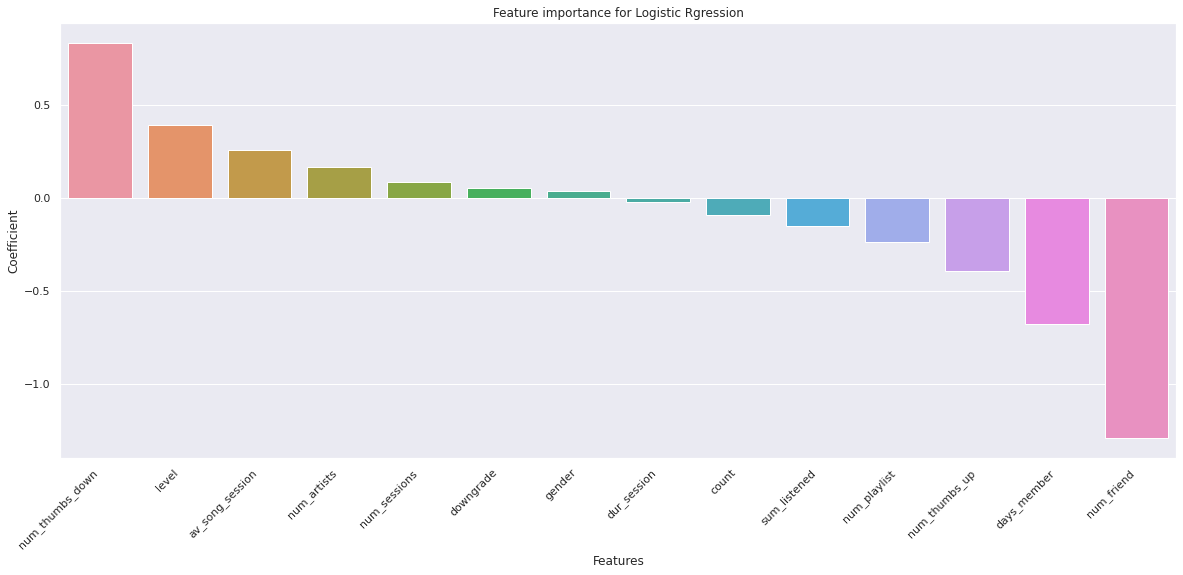

In [52]:
feature_coef = lr_model.coefficients.values.tolist()
feature_coef_df = pd.DataFrame(list(zip(df_final.columns[1:], feature_coef)), columns=['Feature', 'Coefficient'])\
        .sort_values('Coefficient', ascending=False)

plt.figure(figsize=(20,8))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
plt.title('Feature importance for Logistic Rgression')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()

## Decision Tree

In [53]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="scaled_features")
dt_model = dt.fit(train)
results_dt = dt_model.transform(test)

get_model_metrics(results_dt)

Accuracy:  0.95
Precision:  0.95
Recall:  0.74
F1-Score:  0.83


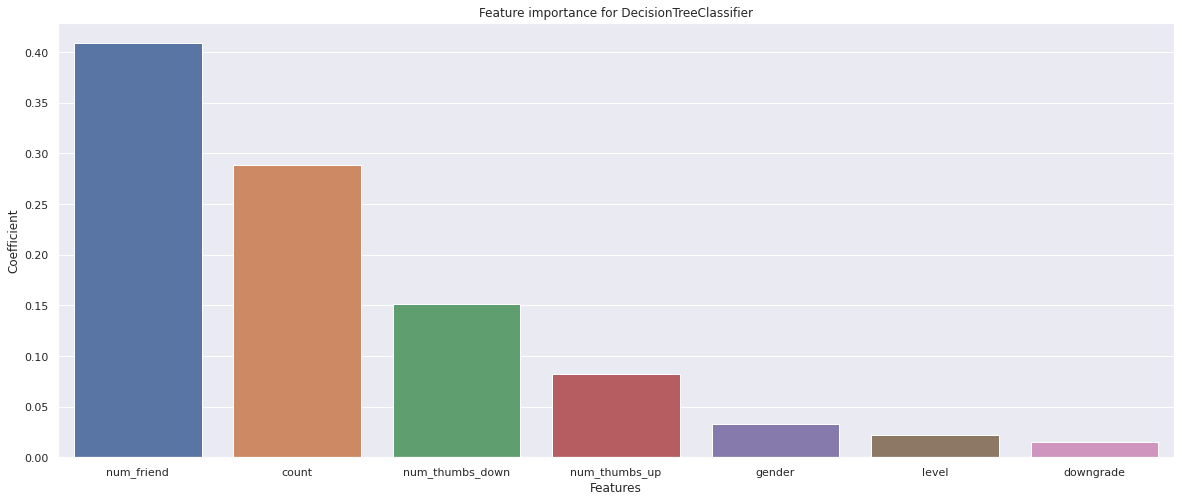

In [54]:
feature_ind = dt_model.featureImportances.indices.tolist()
feature_name = [df_final.columns[1:][ind] for ind in feature_ind]
feature_coef = dt_model.featureImportances.values.tolist()
feature_coef_df = pd.DataFrame(list(zip(df_final.columns[1:], feature_coef)), columns=['Feature', 'Coefficient'])\
            .sort_values('Coefficient', ascending=False)

plt.figure(figsize=(20,8))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
plt.title('Feature importance for DecisionTreeClassifier')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.show()

## Random Forest

In [55]:
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features")
rf_model = rf.fit(train)
results_rf = rf_model.transform(test)

get_model_metrics(results_rf)

Accuracy:  0.94
Precision:  1.0
Recall:  0.65
F1-Score:  0.79


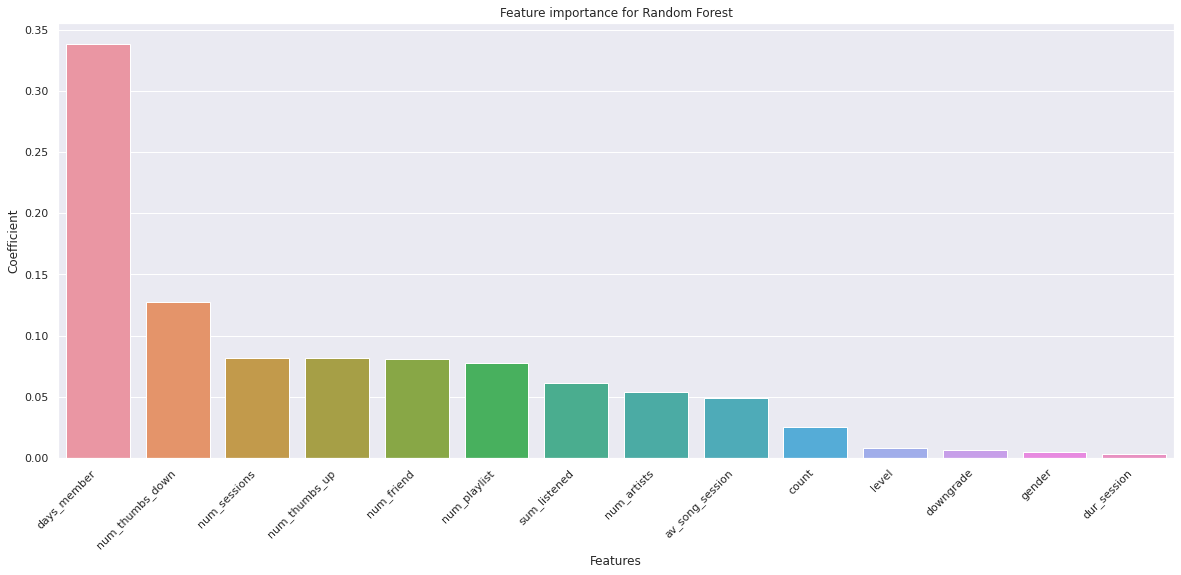

In [56]:
feature_ind = rf_model.featureImportances.indices.tolist()
feature_name = [df_final.columns[1:][ind] for ind in feature_ind]
feature_coef = rf_model.featureImportances.values.tolist()
feature_coef_df = pd.DataFrame(list(zip(df_final.columns[1:], feature_coef)), columns=['Feature', 'Coefficient'])\
            .sort_values('Coefficient', ascending=False)

plt.figure(figsize=(20,8))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
plt.title('Feature importance for Random Forest')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()

## Gradient Boost Tree 

In [57]:
gbt = GBTClassifier(labelCol="label", featuresCol="scaled_features")
gbt_model = gbt.fit(train)
results_gbt = gbt_model.transform(test)

get_model_metrics(results_gbt)

Accuracy:  0.98
Precision:  1.0
Recall:  0.9
F1-Score:  0.95


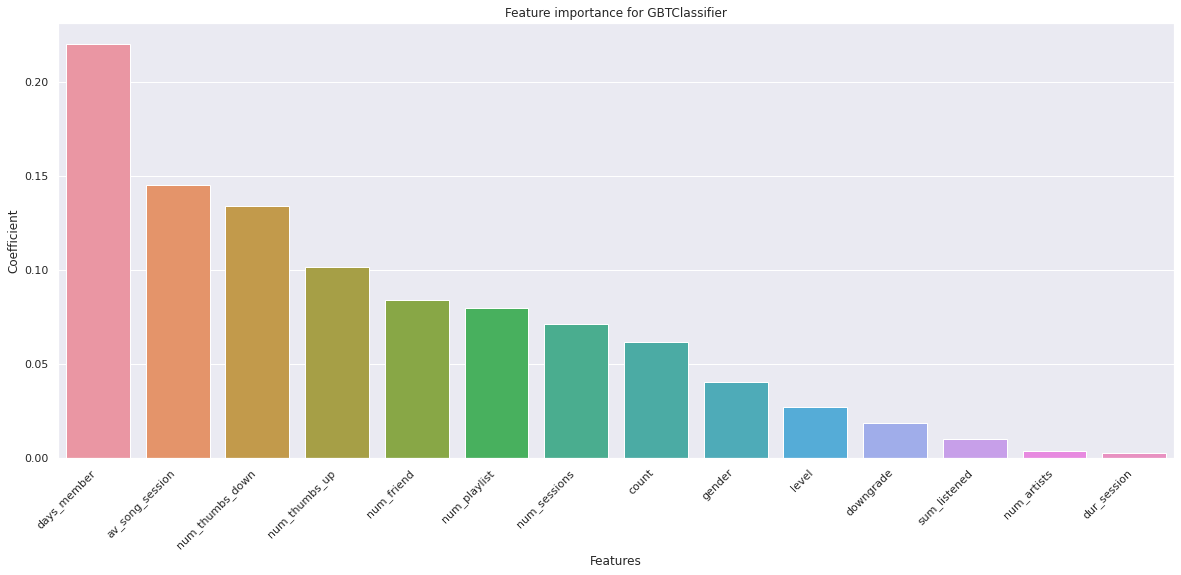

In [58]:
feature_ind = gbt_model.featureImportances.indices.tolist()
feature_name = [df_final.columns[1:][ind] for ind in feature_ind]
feature_coef = gbt_model.featureImportances.values.tolist()
feature_coef_df = pd.DataFrame(list(zip(df_final.columns[1:], feature_coef)), columns=['Feature', 'Coefficient'])\
            .sort_values('Coefficient', ascending=False)

plt.figure(figsize=(20,8))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
plt.title('Feature importance for GBTClassifier')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()

## Accuracy, Precision, Recall and F1-score of different classifiers

|Classifier | Accuracy | Precision | Recall | F1-Score |
| --- | --- | --- | --- | --- | 	 	
|Logistic Regression| 	0.85 |	0.88 |	0.14 |	0.25 |
|Decision Tree| 	0.95 |	0.95 |	0.74 |	0.83 |
|Random Forest | 	0.94 |	1.0 |	0.65 |  0.79 |
|Gradient Boost Tree |	0.98 |	1.0 |	0.90 |	0.95 |